In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - velocity_maps.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Make 2D velocity maps of the nearby MW using the Gaia DR2 + AstroNN catalog
'''

__author__ = "James Lane"

In [2]:
### Imports

## Basic
import numpy as np
import sys, os, pdb
# import glob
# import subprocess
# import copy

## Plotting
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import cm

## Astropy
from astropy.io import fits
from astropy import table
from astropy import units as apu
from astropy.coordinates import CartesianDifferential

## Scipy
from scipy.stats import binned_statistic_2d

In [3]:
### Change Jupyter settings

from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Markdown, display

# Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

# Print using markdown
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [4]:
### Matplotlib

plt.rc('font', size=12)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# Meta

## Future work
- Include both radial and tangential velocity maps for the quasi-isothermal DF

## Information
- B12 model from Equation 7 of Bovy, Prieto, Beers+ 2012

# Load
Load the precut AstroNN catalog and apply a cut on the galactocentric $Z$, then convert values to galactocentric coordinates and velocities.

In [5]:
### Load catalogs
gaiadr2_apogee_catalog = '../../data/generated/gaiadr2-apogee_dataset.FIT'
f = fits.open(gaiadr2_apogee_catalog)
data = f[1].data

In [6]:
### Cut on galactocentric absolute Z < 0.3 kpc
where_low_z = np.where( np.abs(data['Z']) < 0.3 )[0]
data_low_z = data[where_low_z] 
z_select_text = r'$|$Z$_{GC}| < 0.3$ kpc'

In [7]:
### Read catalog values

# ID, RA, Dec, logg, abundances, errors
apid = data_low_z['APOGEE_ID']
locid = data_low_z['LOCATION_ID']
vhelio = data_low_z['VHELIO']
pmll = data_low_z['PM_LL']
pmbb = data_low_z['PM_BB']
gc_x = data_low_z['X']
gc_y = data_low_z['Y']
gc_z = data_low_z['Z']
gc_vx = data_low_z['VX']
gc_vy = data_low_z['VY']
gc_vz = data_low_z['VZ']

In [8]:
### Convert to galactocentric radius and radial velocity
gc_R = np.sqrt(np.square(gc_x)+np.square(gc_y))
gc_phi = np.arctan2(gc_y,gc_x)
gc_vR = np.cos(gc_phi)*gc_vx + np.sin(gc_phi)*gc_vy
gc_vT = -np.sin(gc_phi)*gc_vx + np.cos(gc_phi)*gc_vy

# Plot
Plot each of the following:
- Density of stars
- Galactocentric radial velocity
- Galactocentric tangential velocity
- Heliocentric radial velocity
- Proper motions
- B12 model

## Prepare

In [9]:
### Function definitions

def hist_gcxy(x, y, vals, vmin, vmax, stat, low_N_mask, no_N_mask, cmap):
    
    # Make the histogram using the supplied value and stat. Stat must be 
    # compatible with binned_statistic_2d, either 'median' or np.std
    hist, xedges, yedges, binid = binned_statistic_2d(x, y, values=vals, statistic=stat,
                                                      bins=n_bins, range=hist_range)

    # Plot the image. Rotate to account for histogram => plotting grid
    img = ax.imshow(np.rot90(hist), interpolation='nearest',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                    cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Add the image masks. Assumes same geometry as hist.
    img_mask = ax.imshow(low_N_mask, interpolation='nearest',
                         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    img_mask = ax.imshow(no_N_mask, interpolation='nearest',
                         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

    # Colorbar
    cbar = plt.colorbar(img)
    
    # Add the sun and it's orbit
    ax.scatter(x_sun, 0, marker=r'$\odot$', color='Black', s=256)
    orbit_circle = plt.Circle((0, 0), x_sun, edgecolor='Black', facecolor='None')
    ax.add_artist(orbit_circle)
    
    # Decorate
    ax.set_xlabel(r'X$_{GC}$ [kpc]')
    ax.set_ylabel(r'Y$_{GC}$ [kpc]')
    ax.set_xlim(x_lo, x_hi)
    ax.set_ylim(y_lo, y_hi)
    ax.tick_params(direction='in', top='on', right='on')
    
    return fig, ax, cbar
#def

def B12_model(x_hi, x_lo, y_hi, y_lo, n_bins):
    
    ### Assumes x positive away from galactic center.
    
    # First make a grid of points
    gc_x_samp = -np.linspace(x_lo, x_hi, n_bins)
    gc_y_samp = np.linspace(y_lo, y_hi, n_bins)
    gc_xv_samp, gc_yv_samp = np.meshgrid(gc_x_samp, gc_y_samp)

    # Now convert the points into galactic l and galactocentric phi
    gc_lv_samp = np.arctan2( gc_yv_samp, -1*(gc_xv_samp+x_sun) )
    gc_phiv_samp = np.arctan2( gc_yv_samp, gc_xv_samp )

    # Now calculate the velocity field
    gc_losv_samp = 218*( 1 - 0.0028*np.sqrt(np.square(gc_xv_samp)+np.square(gc_yv_samp)) )*np.sin( gc_phiv_samp + gc_lv_samp ) + (11)*np.cos( gc_lv_samp ) - (245)*np.sin(gc_lv_samp)

    # Now it will be ready for plotting once it is flipped:
    return gc_losv_samp[:,::-1]
#def

In [10]:
### Prepare for plotting

# Bins
n_bins = 25

# Sun
x_sun = -8.125

# Ranges
x_hi = 0
x_lo = -15
y_hi = 10
y_lo = -5
hist_range = [ [x_lo,x_hi], [y_lo,y_hi] ]

# Close existing plots
plt.close('all')

## Stellar density

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


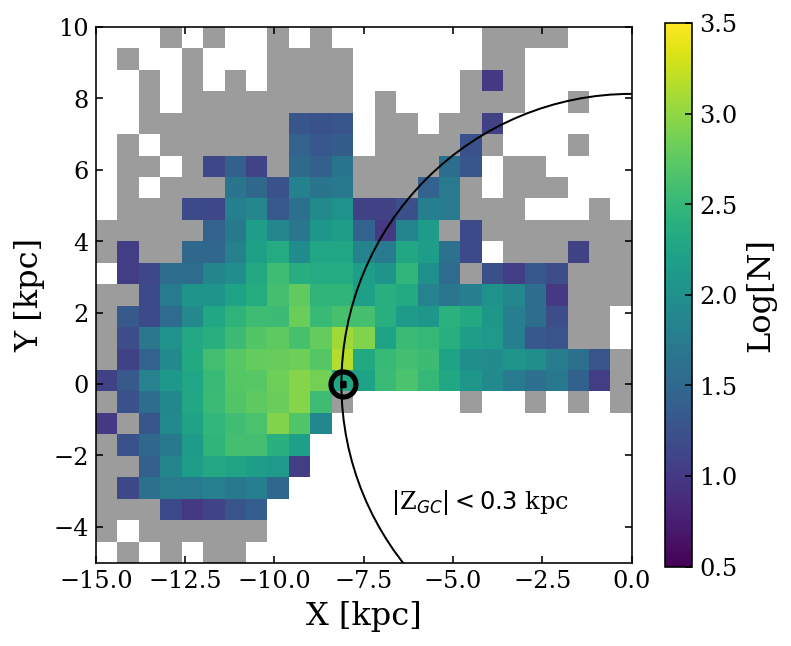

In [11]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

hist, xedges, yedges = np.histogram2d(gc_x, gc_y, bins=n_bins, range=hist_range)

# Rotate to account for histogram -> plotting grid
hist = np.rot90(hist)

# Find low-N bins. As long as histogram geometry remains the same this will be 
# used for greying out values.
where_low_N = np.where( (hist < 10) & (hist > 0) )
low_N_mask = np.zeros((n_bins,n_bins,4))
low_N_mask[:,:,3] = 0.0
low_N_mask[where_low_N[0],where_low_N[1],:3] = 100
low_N_mask[where_low_N[0],where_low_N[1],3] = 1.0

# Find 0-N bins. This will differentiate between no data and too little data
where_no_N = np.where( hist == 0 )
no_N_mask = np.zeros((n_bins,n_bins,4))
no_N_mask[:,:,3] = 0.0
no_N_mask[where_no_N[0],where_no_N[1],:3] = 1
no_N_mask[where_no_N[0],where_no_N[1],3] = 1.0

img = ax.imshow(np.log10(hist), interpolation='nearest',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               cmap='viridis', vmin=0.5, vmax=3.5)
low_N_img = ax.imshow(low_N_mask, interpolation='nearest',
                     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
no_N_img = ax.imshow(no_N_mask, interpolation='nearest',
                     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

cbar = plt.colorbar(img)
ax.scatter(x_sun, 0, marker=r'$\odot$', color='Black', s=256)
orbit_circle = plt.Circle((0, 0), x_sun, edgecolor='Black', facecolor='None')
ax.add_artist(orbit_circle)

ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
cbar.set_label('Log[N]')
ax.annotate(z_select_text, xy=(0.55,0.1), xycoords='axes fraction')

plt.show()
fig.savefig('plots/N_hist.pdf')
plt.close(fig)

# No output
pass;

## Galactocentric radial velocity

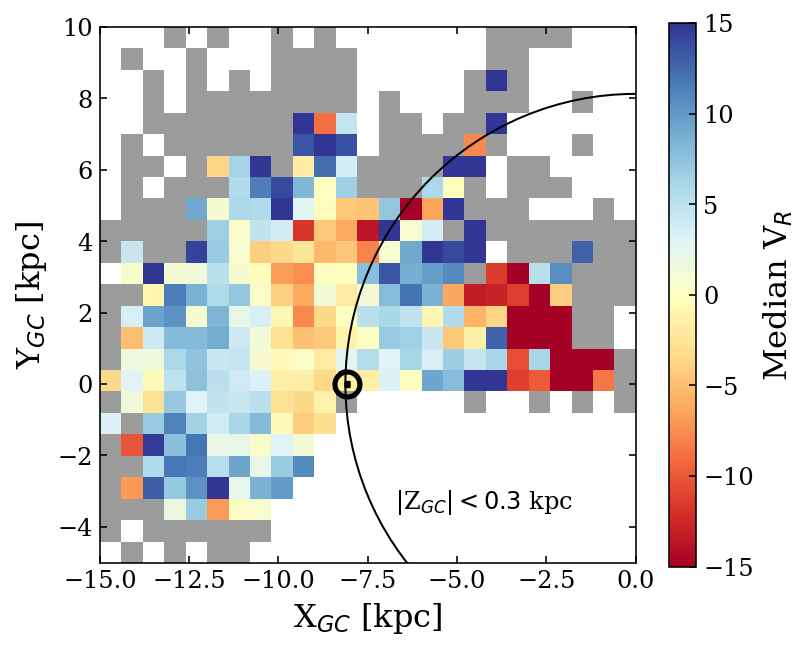

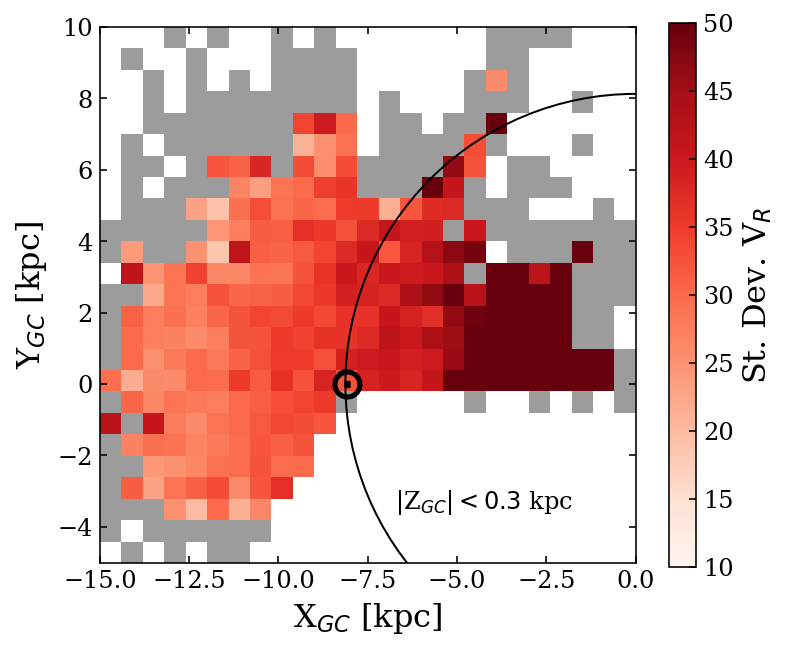

In [12]:
### Values
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

fig, ax, cbar = hist_gcxy(gc_x, gc_y, gc_vR,
                          -15, 15, 'median', low_N_mask, no_N_mask, 'RdYlBu')

cbar.set_label(r'Median V$_{R}$')
ax.annotate(z_select_text, xy=(0.55,0.1), xycoords='axes fraction')

plt.show()
fig.savefig('plots/VR_med_hist.pdf')

### Standard deviation
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

fig, ax, cbar = hist_gcxy(gc_x, gc_y, gc_vR,
                          10, 50, np.std, low_N_mask, no_N_mask, 'Reds')

cbar.set_label(r'St. Dev. V$_{R}$')
ax.annotate(z_select_text, xy=(0.55,0.1), xycoords='axes fraction')

plt.show()
fig.savefig('plots/VR_std_hist.pdf')
plt.close('all')

# No output
pass;

# Galactocentric tangential velocity

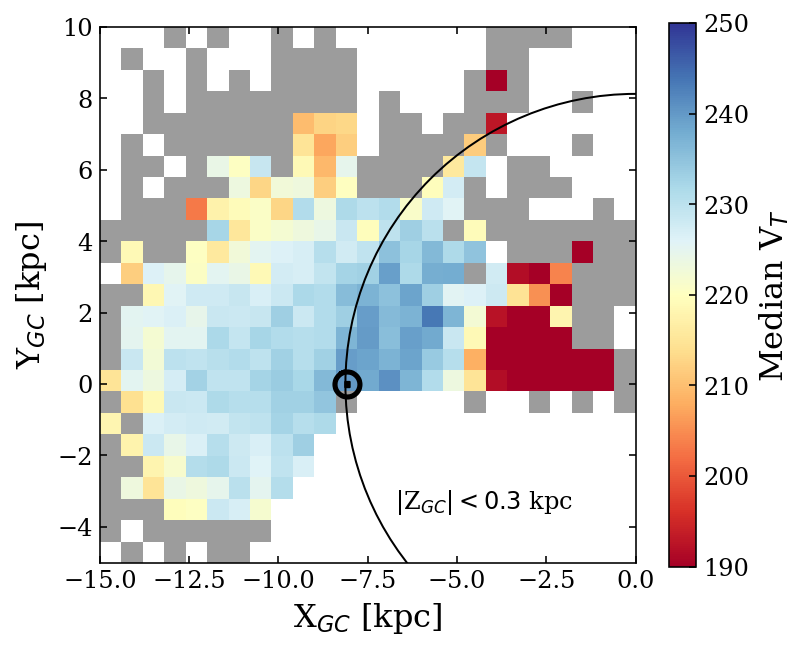

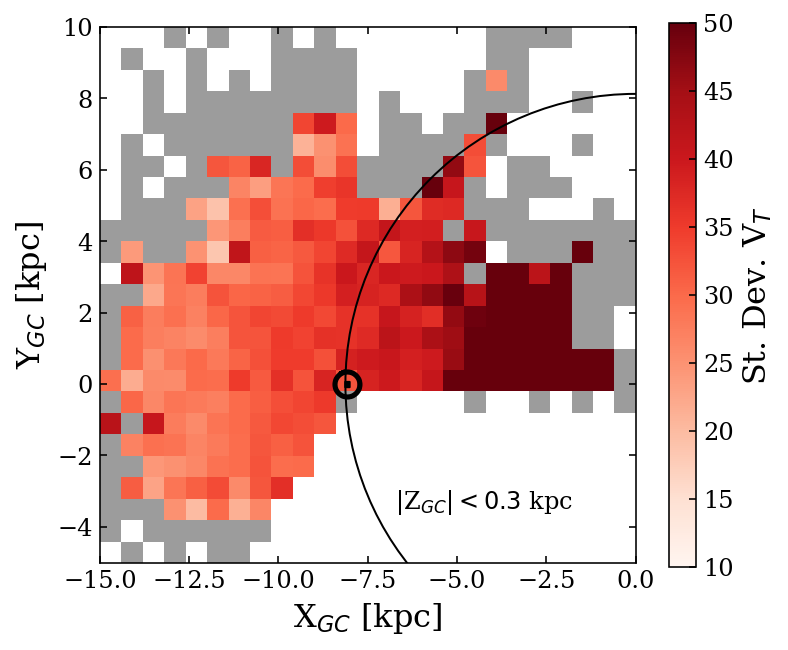

In [13]:
### Values
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

fig, ax, cbar = hist_gcxy(gc_x, gc_y, -gc_vT,
                          190, 250, 'median', low_N_mask, no_N_mask, 'RdYlBu')

cbar.set_label(r'Median V$_{T}$')
ax.annotate(z_select_text, xy=(0.55,0.1), xycoords='axes fraction')

plt.show()
fig.savefig('plots/VT_med_hist.pdf')

### Standard deviation
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

fig, ax, cbar = hist_gcxy(gc_x, gc_y, gc_vR,
                          10, 50, np.std, low_N_mask, no_N_mask, 'Reds')

cbar.set_label(r'St. Dev. V$_{T}$')
ax.annotate(z_select_text, xy=(0.55,0.1), xycoords='axes fraction')

plt.show()
fig.savefig('plots/VT_std_hist.pdf')
plt.close('all')

# No output
pass;

## Heliocentric radial velocity

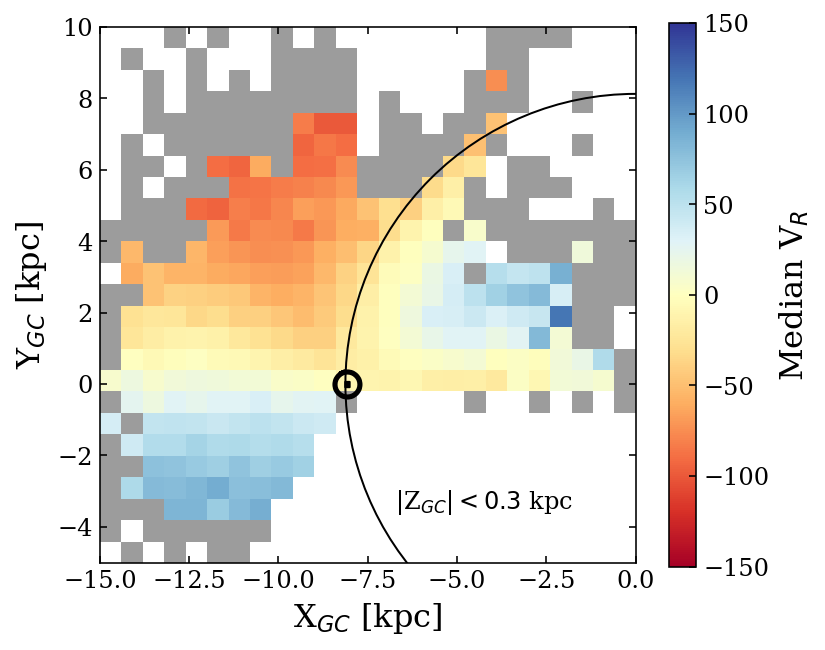

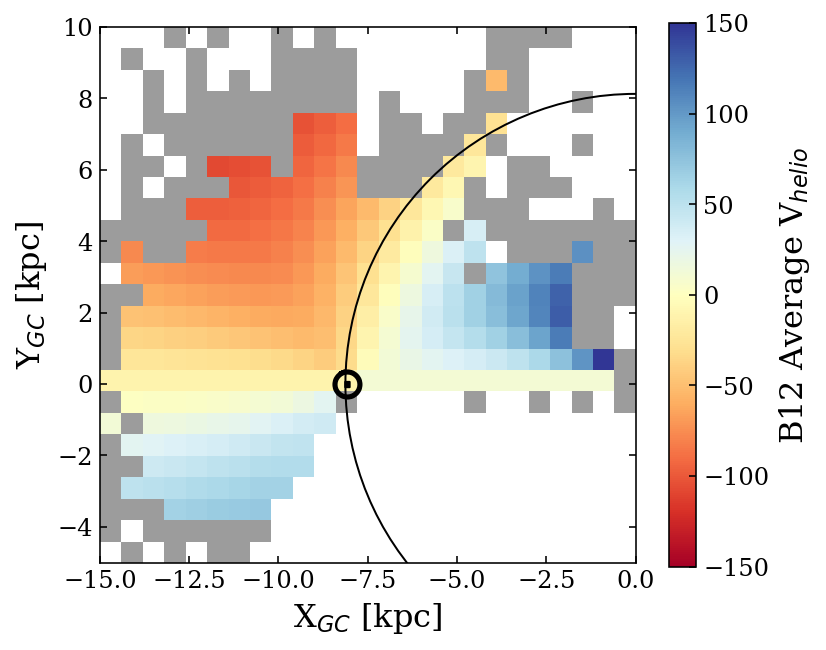

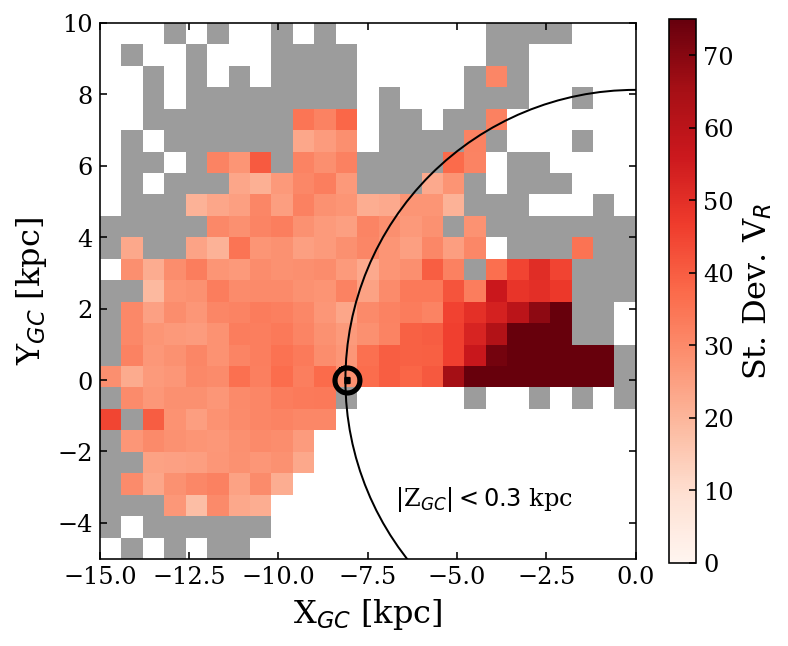

In [14]:
### Values
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

fig, ax, cbar = hist_gcxy(gc_x, gc_y, vhelio,
                          -150, 150, 'median', low_N_mask, no_N_mask, 'RdYlBu')

cbar.set_label(r'Median V$_{R}$')
ax.annotate(z_select_text, xy=(0.55,0.1), xycoords='axes fraction')

plt.show()
fig.savefig('plots/Vhel_med_hist.pdf')

### B12 Model
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

# Make the grid
gc_losv_samp = B12_model(x_lo, x_hi, y_lo, y_hi, n_bins)

# Plot the image. Rotate to account for histogram => plotting grid
img = ax.imshow(gc_losv_samp, interpolation='nearest',
                extent=[x_lo, x_hi, y_lo, y_hi],
                cmap='RdYlBu', vmin=-150, vmax=150)

# Add the image masks. Assumes same geometry as hist.
img_mask = ax.imshow(low_N_mask, interpolation='nearest',
                     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
img_mask = ax.imshow(no_N_mask, interpolation='nearest',
                     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

# Colorbar
cbar = plt.colorbar(img)

# Add the sun and it's orbit
ax.scatter(x_sun, 0, marker=r'$\odot$', color='Black', s=256)
orbit_circle = plt.Circle((0, 0), x_sun, edgecolor='Black', facecolor='None')
ax.add_artist(orbit_circle)

# Decorate
ax.set_xlabel(r'X$_{GC}$ [kpc]')
ax.set_ylabel(r'Y$_{GC}$ [kpc]')
ax.set_xlim(x_lo, x_hi)
ax.set_ylim(y_lo, y_hi)
ax.tick_params(direction='in', top='on', right='on')
cbar.set_label(r'B12 Average V$_{helio}$')

plt.show()
fig.savefig('plots/B12_model_sample.pdf')

### Standard deviation
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

fig, ax, cbar = hist_gcxy(gc_x, gc_y, vhelio,
                          0, 75, np.std, low_N_mask, no_N_mask, 'Reds')

cbar.set_label(r'St. Dev. V$_{R}$')
ax.annotate(z_select_text, xy=(0.55,0.1), xycoords='axes fraction')

plt.show()
fig.savefig('plots/Vhel_std_hist.pdf')
plt.close('all')

# No output
pass;

## Proper motion galactic longitude

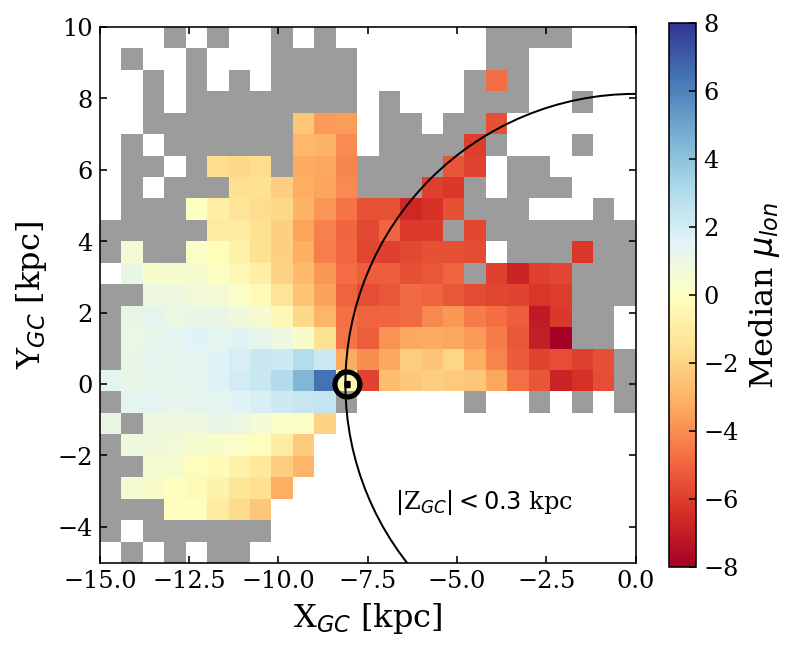

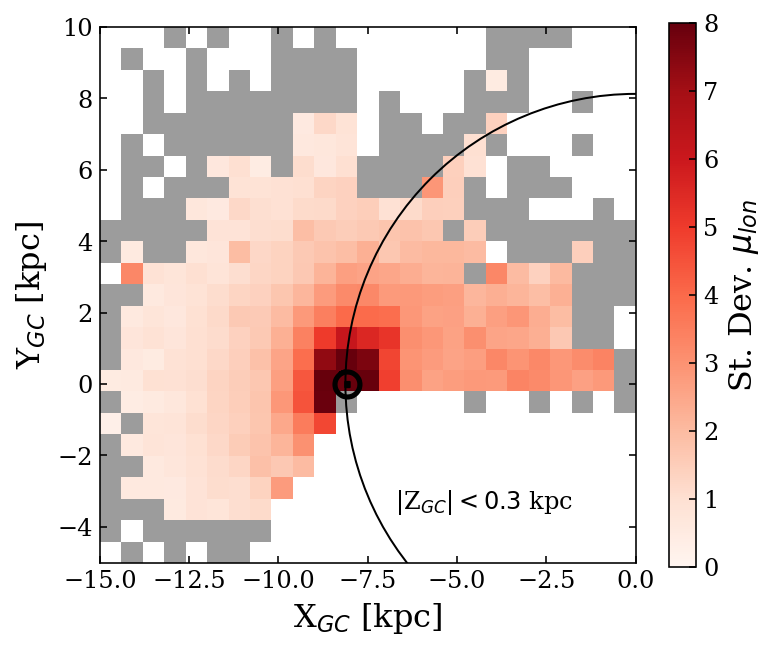

In [15]:
# Values
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

fig, ax, cbar = hist_gcxy(gc_x, gc_y, pmll,
                          -8, 8, 'median', low_N_mask, no_N_mask, 'RdYlBu')

cbar.set_label(r'Median $\mu_{lon}$')
ax.annotate(z_select_text, xy=(0.55,0.1), xycoords='axes fraction')

plt.show()
fig.savefig('plots/pmll_med_hist.pdf')

# Standard deviation
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

fig, ax, cbar = hist_gcxy(gc_x, gc_y, pmll,
                          0, 8, np.std, low_N_mask, no_N_mask, 'Reds')

cbar.set_label(r'St. Dev. $\mu_{lon}$')
ax.annotate(z_select_text, xy=(0.55,0.1), xycoords='axes fraction')

plt.show()
fig.savefig('plots/pmll_err_hist.pdf')
plt.close('all')

# No output
pass;

## Proper motion galactic latitude

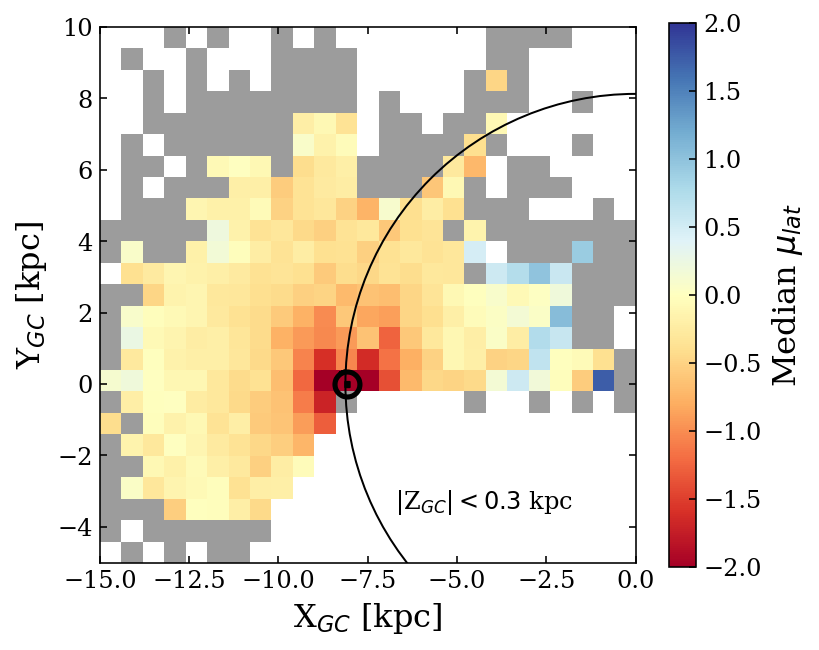

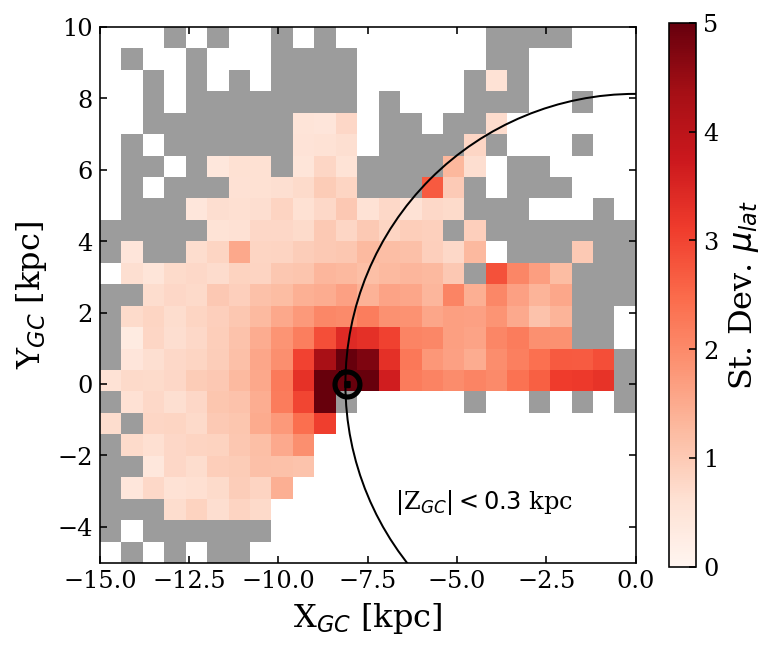

In [16]:
# Values.
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

fig, ax, cbar = hist_gcxy(gc_x, gc_y, pmbb,
                          -2, 2, 'median', low_N_mask, no_N_mask, 'RdYlBu')

cbar.set_label(r'Median $\mu_{lat}$')
ax.annotate(z_select_text, xy=(0.55,0.1), xycoords='axes fraction')

plt.show()
fig.savefig('plots/pmbb_med_hist.pdf')

# Standard deviation
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

fig, ax, cbar = hist_gcxy(gc_x, gc_y, pmbb,
                          0, 5, np.std, low_N_mask, no_N_mask, 'Reds')

cbar.set_label(r'St. Dev. $\mu_{lat}$')
ax.annotate(z_select_text, xy=(0.55,0.1), xycoords='axes fraction')

plt.show()
fig.savefig('plots/pmbb_err_hist.pdf')
plt.close('all')

# No output
pass;

## Make plots of the B12 model

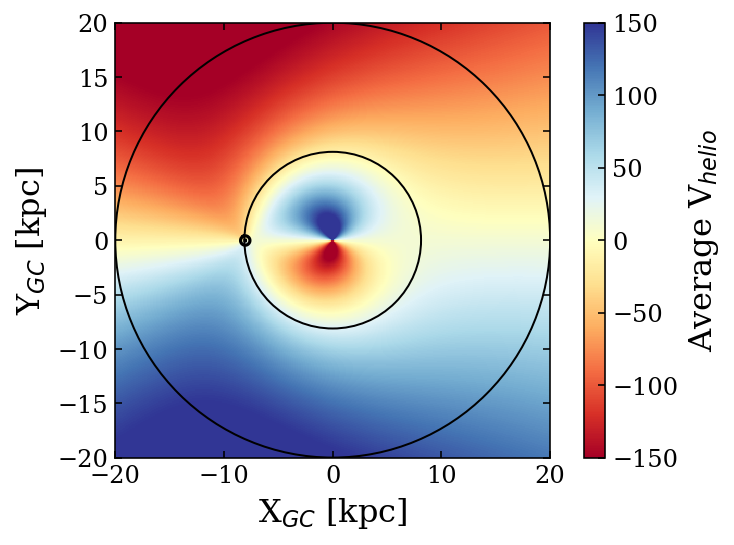

In [17]:
# First make a grid of points
gc_losv_samp = B12_model(-20,20,-20,20,400)

fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the image. Rotate to account for histogram => plotting grid
img = ax.imshow(gc_losv_samp, interpolation='nearest',
                extent=[-20,20,-20,20],
                cmap='RdYlBu', vmin=-150, vmax=150)

# Colorbar
cbar = plt.colorbar(img)

# Add the sun and it's orbit
ax.scatter(x_sun, 0, marker=r'$\odot$', color='Black')
orbit_circle = plt.Circle((0,0), x_sun, edgecolor='Black', facecolor='None')
outter_circle = plt.Circle((0,0), 20, edgecolor='Black', facecolor='None')
ax.add_artist(orbit_circle)
ax.add_artist(outter_circle)

# Decorate
ax.set_xlabel(r'X$_{GC}$ [kpc]')
ax.set_ylabel(r'Y$_{GC}$ [kpc]')
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.tick_params(direction='in', top='on', right='on')
cbar.set_label(r'Average V$_{helio}$')

plt.show()
fig.savefig('plots/B12_model_full.pdf')

# No output
pass;

# End